In [1]:
import monai
from monai.transforms import (
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    Spacingd,
    RandWeightedCrop,
    RandRotate,
    Rand3DElasticd,
    RandRotated,
    EnsureChannelFirstd,
    ScaleIntensityd,
    RandFlipd)
import tqdm
from torchmetrics import MeanSquaredError
import time
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, Dataset ,nifti_saver, PatchDataset, DataLoader
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob
from monai.networks.blocks import Convolution
from monai.networks.nets import Discriminator, Generator
from monai.utils import progress_bar
import torch.nn as nn
import torchmetrics 

/local/fogunsan.5668692.0/tmp/kslurm-venv-r7f6d20d/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gad_t1= sorted(glob('/home/fogunsan/scratch/degad/derivatives/passing_dataset/*/*_acq-gad_resampled_T1w.nii.gz'))# gad images who's corresponding nongad images underwent a rigid transform
nongad_t1= sorted(glob('/home/fogunsan/scratch/degad/derivatives/normalized_fcm/*/*_acq-nongad_normalized_fcm.nii.gz')) # nongad images which underwent a rigid transform and underwent fcm normalization
image_dict = [{"image": gad_name, "label": nongad_name} for gad_name, nongad_name in zip(gad_t1,nongad_t1)] #creates list of dictionaries, with gad and nongad images labelled
print(len(image_dict))
train_files, validate_files, test_files = image_dict[0:33], image_dict[33:42], image_dict[42:47] #creates a list of dictionaries for each set (training, val, testing), with keys of gad and nongad in each index 

47


In [3]:
num_train_files = len(train_files)
num_validate_files = len(validate_files)
num_patches = 20000 #patches per image
batch_size = 10
training_sample_size = int(num_train_files * num_patches / batch_size)
validate_sample_size = int(num_validate_files * num_patches / batch_size)
load_images= Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys = ["image"], minv=0.0, maxv=1.0)])# applying min max normalization only on gad images
    
train_imgs_cache = CacheDataset(data=train_files, transform=load_images)
validate_imgs_cache = CacheDataset(data=validate_files, transform=load_images)

patching_func= RandCropByPosNegLabeld( # gonna use this function to create patches
            keys = ["image", "label"],
            label_key = "image",
            spatial_size=(32,32,32),
            pos = 1,
            neg = 0.0001, # much larger probability of sampling foreground
            num_samples= num_patches# CHANGE BACK TO 5000
        )
patch_transforms = Compose([RandRotated(keys =["image", "label"], range_x = [0.8,0.8], range_y = [0.8,0.8], range_z = [0.8,0.8], prob = 0.4), RandFlipd(keys =["image", "label"], prob = 0.2, spatial_axis=1)])# flipping along y-axis (horizontally)

train_patches_dataset = PatchDataset(data = train_imgs_cache, patch_func=patching_func, samples_per_image=num_patches, transform = patch_transforms)
validate_patches_dataset = PatchDataset(data = validate_imgs_cache, patch_func=patching_func, samples_per_image=num_patches, transform = patch_transforms)

Loading dataset: 100%|██████████| 9/9 [00:27<00:00,  3.05s/it]


In [4]:
CNN=UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=1,
            channels=(16, 32,64,128,256,512,512,512),
            strides=(2, 2, 2, 2,1,1,1),
            dropout= 0.2,
        )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
CNN.apply(monai.networks.normal_init)
CNN_model = CNN.to(device)


In [5]:
import time
learning_rate = 2e-4
betas = (0.5, 0.999)
cnn_opt = torch.optim.Adam(CNN_model.parameters(), lr = learning_rate, betas=betas)

start = time.time() # initializing variable to calculate training time
max_epochs = 100 # max total iterations over entire training set
mean_squared = MeanSquaredError(squared = False).to(device) # metric for validation calculated at the end of each epoch
mse_error = [0] # list of validation loss calculated at the end of each epoch
epoch_loss_values = [0] # list of training loss calculated at the end of each epoch
train_loader = DataLoader(train_patches_dataset, batch_size=batch_size, shuffle=True)
print('finished loading dataloader')
val_loader = DataLoader(validate_patches_dataset, batch_size=batch_size, shuffle=True)
for epoch in range(max_epochs):
    CNN_model.train() # setting model to training mode
    epoch_loss = 0 # total traininig loss in an epoch
    for i,train_batch in enumerate(train_loader): # iterating through dataloader
        
        progress_bar(
            index=i+1, # displays what step we are of current epoch, our epoch number, training (rmse loss) 
            count = training_sample_size, 
            desc= f"epoch {epoch + 1}, training rmse loss: {epoch_loss_values[-1]:.4f}",
            newline = True
        ) # progress bar to display current stage in training
        cnn_opt.zero_grad()
        gad_images = train_batch['image'].cuda()# gad images of batch
        nongad_images = train_batch['label'].cuda() # nongad images of batch
        degad_images = CNN_model(gad_images) # feeding CNN with gad images
        mse_loss= nn.MSELoss() 
        loss = torch.sqrt(mse_loss(degad_images, nongad_images))# convert mse to rmse
        loss.backward()
        cnn_opt.step()
        epoch_loss += loss.item() # adding loss for this batch to the total training loss for this epoch
    
    epoch_loss_values.append(epoch_loss / training_sample_size) # append total epoch loss divided by the number of steps in sample to the epoch loss list
    CNN_model.eval() #setting model to evaluation mode for training
    with torch.no_grad():
        mean_squared.reset() # resetting metric state for every epoch
        mse_total_epoch = 0 # mean squared error for the entire epoch
        for i,val_batch in enumerate(val_loader): # iterating through dataloader
            progress_bar(
            index=i+1, # displays what step we are of current epoch, our epoch number,  val (rmse metric) values
            count = training_sample_size, 
            desc= f"epoch {epoch + 1}, validation rmse metric: {mse_error[-1]:.4f}",
            newline = True
        )   #progress bar to display current stage in training
            gad_images =val_batch["image"].cuda()# batch with gad images
            nongad_images = val_batch["label"].cuda() # batch with nongad images
            degad_images = CNN_model(gad_images)
            val_mse = mean_squared(degad_images, nongad_images)
            mse_total_epoch = mse_total_epoch + val_mse # adding mse of this batch to total epoch mse
        mse_error.append(mse_total_epoch.item()/(validate_sample_size )) # dividing total mse in this epoch by the number of batches -> add to list of epoch mse
        
end = time.time()
time = end - start
print(time)

finished loading dataloader
1/66000 epoch 1, training rmse loss: 0.0000 [                              ]
2/66000 epoch 1, training rmse loss: 0.0000 [                              ]
3/66000 epoch 1, training rmse loss: 0.0000 [                              ]
4/66000 epoch 1, training rmse loss: 0.0000 [                              ]
5/66000 epoch 1, training rmse loss: 0.0000 [                              ]


KeyboardInterrupt: 

In [ ]:
with open ('/home/fogunsan/scratch/degad/derivatives/UNET/April20/model_stats.txt', 'w') as file:  
    file.write(f'training time: {time}\n')  
    file.write(f'training loss: {epoch_loss_values[-1]} validation loss: {mse_error[-1]}')

In [ ]:
torch.save(CNN_model.state_dict(), "/home/fogunsan/scratch/degad/derivatives/UNET/April20/trained_unet.pt")

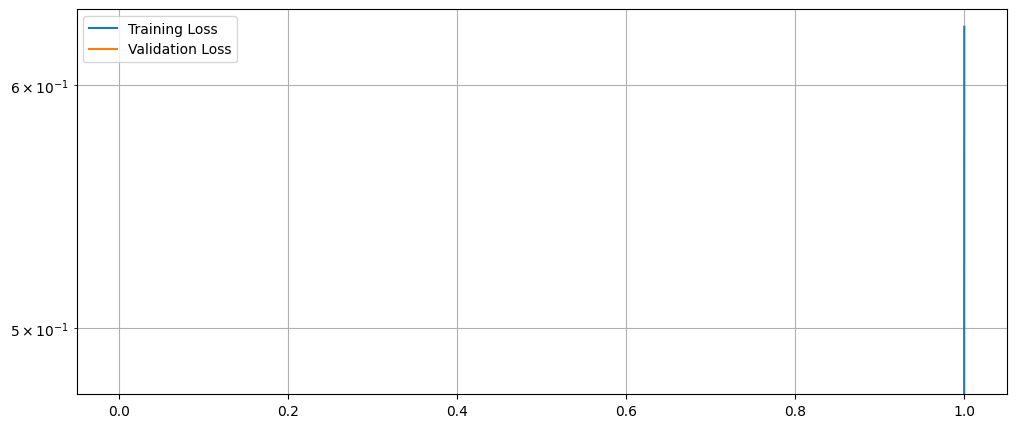

In [27]:
plt.figure(figsize=(12, 5))
plt.semilogy(*zip(*epoch_loss_values), label="Training Loss")
plt.semilogy(*zip(*mse_error), label="Validation Loss")
plt.grid(True, "both", "both")
plt.legend()
plt.savefig('/home/fogunsan/scratch/degad/derivatives/UNET/April20/lossfunction.png')
